In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import preproc_dir, analysis_dir, database_dir, cache_dir
from storage import get_storage_functions, quantize
from im_patches import get_patches_from_grid
from cross_val_pred import standardize, cv_split_by_image, cv_ridge_predict_eval

# Parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
# response windows
# - one (long) window, if > 0
t_win  =   0
# - OTHERWISE, sliding window
t_pre  = 200
t_post = 375  # inclusive, but window must fit fully in range
t_step =  10


#============================================================================
# fixation/saccade selection
#============================================================================
# fixation criteria
ifix_sel = 2  # 0: zeroth-fix only; 1: non-zeroth-fix only; otherwise: both


#============================================================================
# modelling
#============================================================================
# ridge regularization
ridge_alpha = 100000

# cross-validation
n_splits    =      5
group_kfold =   True


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir

# if t_win > 0:
latency_path = database_dir + 'per_unit_latency-fix_on.csv.gz'
# else:
sdf_dir = preproc_dir
sdf_suffix = '-mwa_1' if t_win > 0 else '-mwa_50'  # default to no smoothing if using a response window

rf_fit_path = database_dir + 'per_unit_rf.csv.gz'

feat_dir = cache_dir + 'feats/vit_large_patch16_384/blocks.13.attn.qkv'
feat_suffix = '_as_4x4_in_1.00_steps'

unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

output_dir = analysis_dir + 'vision_model'

In [3]:
# Parameters
sess_name = "Pa210201"
t_win = 200
sdf_suffix = "-mwa_1"
ifix_sel = 1
output_dir = "../test_results/fix1"


# Check prereqs and params

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

with h5.File(proc_path, 'r') as f:
    im_w, im_h = im_size = f['stimulus/size_dva'][()]
feats_path = Path(feat_dir) / f'{im_w:.1f}x{im_h:.1f}{feat_suffix}.h5'
print('Loading cached model features from', feats_path)
feats_path = feats_path.expanduser()
assert feats_path.is_file()

if t_win > 0:
    print('Using per-unit latency from', latency_path)
    latency_path = Path(latency_path).expanduser()
    assert latency_path.is_file()

rf_fit_path = Path(rf_fit_path)
print('Loading Gaussian-fitted RF maps density function from', rf_fit_path)
rf_fit_path = rf_fit_path.expanduser()
assert rf_fit_path.is_file()

if unit_sel_path is not None:
    print('Loading unit selection from', unit_sel_path)
    unit_sel_path = Path(unit_sel_path).expanduser()
    assert unit_sel_path.is_file()
    unit_names = pd.read_csv(unit_sel_path).set_index('Session').loc[[sess_name]]['Unit'].values
else:
    unit_names = None

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading spike density function from ../test_data/Pa210201-sdf-mwa_1.h5
Loading cached model features from ~/Data/FreeViewing/Cache/feats/vit_large_patch16_384/blocks.13.attn.qkv/16.0x16.0_as_4x4_in_1.00_steps.h5
Using per-unit latency from ../db/per_unit_latency-fix_on.csv.gz
Loading Gaussian-fitted RF maps density function from ../db/per_unit_rf.csv.gz
Loading unit selection from ../db/unit_sel/visually_selective.csv.gz
Saving results to ../test_results/fix1/Pa210201.h5


In [5]:
analysis_name = 'vision_model'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [6]:
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')
with h5.File(proc_path, 'r') as f:
    stim_folder_ = f['stimulus/folder'][()].decode()

# Gather MD5s for images in this session.
# The image MD5 is the index to access cached features at `feats_path`.
# (All images in this project have unique MD5s.)
imids = fix_df.groupby(['Image subdir', 'Image filename']).first().index
md5s = [Path(fn).stem for _, fn in imids]  # uploaded images are already named by their MD5
md5_catalog = pd.DataFrame(index=imids, data=md5s, columns=['MD5'])

# Prepare parameters; save config

In [7]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]

    fix_sel = f['fixation_selection/fixation_indices'][()]
    if ifix_sel in (0, 1):
        m = 0 == fix_df.index.get_level_values(fix_df.index.names.index('Fixation'))[fix_sel]
        if ifix_sel == 1:
            m = ~m
        fix_sel = fix_sel[m]

print('random_seed:', random_seed)

random_seed: 775418045


In [8]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [9]:
group = analysis_name + '/'
save_results(group+'sdf_suffix', sdf_suffix)
save_results(group+'fixation_selection', fix_sel)

group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)
save_results(group+'ifix_sel', ifix_sel)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_win', t_win)
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/modelling/'
save_results(group+'n_splits', n_splits)
save_results(group+'ridge_alpha', ridge_alpha)
save_results(group+'group_kfold', group_kfold)

# Define RFs

In [10]:
with h5.File(sdf_path, 'r') as f:
    unit_names = f['sdf'].attrs['unit_names'].astype(str)
    if 'unit_names' in f:
        copy_group(f, 'unit_names', analysis_name+'/unit_names')

unit_names0 = unit_names.copy()

In [11]:
unit_rf_df = pd.read_csv(rf_fit_path).set_index('Session')
assert sess_name in unit_rf_df.index, 'No unit has good RF fits'

unit_rf_df = unit_rf_df.loc[[sess_name]].set_index('Name')
assert not unit_rf_df.index.has_duplicates
unit_names = unit_rf_df.index.intersection(unit_names).values
print(f'{len(unit_names)} of {len(unit_names0)} ({(len(unit_names)/len(unit_names0))*100:.1f}%) units have fitted RFs')

unit_rf_df = unit_rf_df.loc[unit_names].reset_index()
assert len(unit_rf_df) == len(unit_names)
print('Num units using RF fit from each source:')
print('\t' + '\n\t'.join(str(unit_rf_df.groupby('Source').count()['x']).split('\n')[:-1]))

92 of 92 (100.0%) units have fitted RFs
Num units using RF fit from each source:
	Source
	Channel    13
	Default    39
	Unit       40


In [12]:
save_results(analysis_name+'/unit_names', unit_names.astype(bytes))
unit_rf_df.to_hdf(output_path, analysis_name+'/rf_per_unit', mode='a', format='table', complevel=9, complib='zlib')
unit_rf_df['Index'] = np.arange(len(unit_rf_df))

# Get aligned responses

In [13]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    all_unit_names = dset.attrs['unit_names'].astype(str)
    if unit_names is None:
        unit_names = all_unit_names
        unit_sel = slice(None)
        if 'unit_names' in f:
            copy_group(f, 'unit_names', analysis_name+'/unit_names')
    else:
        all_unit_names = list(all_unit_names)
        unit_sel = np.array([v in unit_names for v in all_unit_names])

    sdf = dset[()][:,unit_sel]

n_neur = sdf.shape[1]

In [14]:
if t_win > 0:
    lat_df = pd.read_csv(latency_path).set_index('Session').loc[[sess_name]].set_index('Name')
    m = pd.Series(unit_names).isin(lat_df.index)
    assert m.all(), f'missing latency value for {(~m).sum()} of {m.size} units'
    assert not lat_df.index.has_duplicates
    lat_df = lat_df.loc[unit_names].reset_index()
    assert len(lat_df) == len(unit_names)
    lat_df['Index'] = np.arange(len(lat_df))
    lat_df['Latency'] = np.clip(lat_df['Latency'], 40, None)
    print('Num units using RF fit from each source:')
    print('\t' + '\n\t'.join(str(lat_df.groupby('Source').count()['Latency']).split('\n')[:-1]))
    lat_df.to_hdf(output_path, analysis_name+'/latency_per_unit', mode='a', format='table', complevel=9, complib='zlib')

Num units using RF fit from each source:
	Source
	Array                 29
	Array, across sess    40
	Channel               11
	Unit                  12


In [15]:
t0s = fix_df.iloc[fix_sel]['Time'].values
if t_win > 0:
    ts = np.array([t_win/2])  # placeholder; actual window varies with latency per unit
else:
    ts = np.arange(-t_pre, t_post+.1, t_step)
resps = np.empty_like(sdf, shape=(fix_sel.size, ts.size, n_neur))

if t_win > 0:
    t_win_ = np.array([0, t_win])
    lat_groups = [(dt, df_['Index'].values) for dt, df_ in lat_df.groupby('Latency')]
    for i, t in enumerate(t0s):
        for dt, usel in lat_groups:
            s = slice(*np.round(t+dt+t_win_).astype(int))
            resps[i,0,usel] = sdf[s,usel].mean(0)
else:
    for i, t in enumerate(t0s):
        ts_ = np.round(t+ts).astype(int)
        resps[i] = sdf[ts_,:]

del sdf

In [16]:
Y = standardize(resps)
Y.shape, Y.dtype

((4700, 1, 92), dtype('float32'))

In [17]:
save_results(analysis_name+'/unit_names', unit_names.astype(bytes))
save_results(analysis_name+'/mean_responses', resps.mean(0), attrs=dict(
    dims=np.array(['time', 'unit'], dtype=bytes),
    n_fix=resps.shape[0]))

# Define splits (group k-fold)

In [18]:
imfns = fix_df.iloc[fix_sel]['Image filename']

splits, train_mask = cv_split_by_image(
    imfns, n_splits,
    group_kfold=group_kfold, random_seed=random_seed)

For group k-fold, loading catalog of similar images
accounting for 0 pairs of similar images
num training and testing points per split:
split 0		train:  3760 test: 940
split 1		train:  3760 test: 940
split 2		train:  3760 test: 940
split 3		train:  3760 test: 940
split 4		train:  3760 test: 940


In [19]:
save_results(analysis_name+'/fix_is_train', train_mask, attrs=dict(
    dims=np.array(['split', 'fixation'], dtype=np.bytes_),
    random_seed=random_seed,
    group_kfold=group_kfold))

# Load pre-computed model reprs

In [20]:
with h5.File(feats_path, 'r') as f:
    patch_locs_x = f['config/patch_grid/x_locs'][()]
    patch_locs_y = f['config/patch_grid/y_locs'][()]
    patch_step = float(f['config/patch_grid/step'][()])

    bg_feats = f['feats/bg'][()]

    all_md5s = f['md5'][()].astype(str)
    all_md5s = pd.Series(index=all_md5s, data=np.arange(len(all_md5s)), name='Index in file')
    idc = all_md5s.loc[md5_catalog['MD5'].values]
    md5_catalog['Index'] = np.arange(len(md5_catalog))

    patch_grid_feats = np.empty(shape=(idc.size,patch_locs_x.size,patch_locs_y.size)+bg_feats.shape, dtype=bg_feats.dtype)
    for ii, i in enumerate(idc.values):
        patch_grid_feats[ii] = f['feats/patch_grid'][i]  # shape (n_patches_x, n_patches_y,) + feats_shape

    copy_group(f, 'config', analysis_name+'/config/feats')

feats_shape = bg_feats.shape
print('Features shape:', feats_shape)
print('Patch-grid features shape:', patch_grid_feats.shape)

iims = np.array([
    md5_catalog.loc[(row['Image subdir'], row['Image filename']), 'Index']
    for i, (_, row) in enumerate(fix_df.iloc[fix_sel].iterrows())])
patch_bins_x = np.concatenate([
    patch_locs_x-patch_step/2, [patch_locs_x[-1]+patch_step/2]])
patch_bins_y = np.concatenate([
    patch_locs_y-patch_step/2, [patch_locs_y[-1]+patch_step/2]])

Features shape: (3072,)
Patch-grid features shape: (793, 19, 19, 3072)


In [21]:
def recon_stim(*args, **kwargs):
    return get_patches_from_grid(
        *args, patch_bins_x=patch_bins_x, patch_bins_y=patch_bins_y, **kwargs)

# Main

In [22]:
n_win = len(ts)
n_split = n_splits
n_unit = len(unit_names)

cv_corrs = np.full((n_win, n_unit), np.nan, dtype=np.float32)
cv_corrs_per_split = np.full((n_win, n_split, n_unit), np.nan, dtype=np.float32)

In [23]:
xys_fix = fix_df.iloc[fix_sel][['Relative X', 'Relative Y']].values.astype(float)

for igroup, ((rf_x, rf_y), df_) in enumerate(tqdm(unit_rf_df.groupby(['x', 'y']))):
    usel = df_['Index'].values
    X = standardize(recon_stim(iims, xys_fix+[rf_x,rf_y], patch_grid_feats, bg_feats))
    corr, _, corr_pers, _ = cv_ridge_predict_eval(X, Y[...,usel], splits, ridge_alpha)
    cv_corrs[:,usel] = corr
    cv_corrs_per_split[:,:,usel] = corr_pers

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:02<00:00,  2.09s/it]

In [24]:
dims = np.array(('time', 'split', 'unit'))
coords = dict((
    ('time', ts),
    ('unit', unit_names)))
attrs = dict(
    ifix_sel=ifix_sel,
    n_fix=fix_sel.size,
    group_kfold=int(group_kfold),
    feat_shape=feats_shape,
    ridge_alpha=ridge_alpha,
    t_aln='fix_on')

q = lambda x: quantize(x, 3)
data_vars = {
    'corr': (dims[[0,2]], q(cv_corrs)),
    'corr_per_split': (dims, q(cv_corrs_per_split))}
dataset = xr.Dataset(data_vars, coords=coords, attrs=attrs)

compr = dict(zlib=True, complevel=9)
encoding = {
    k: dict(chunksizes=v.shape, **compr)
    for k, v in dataset.data_vars.items()}
dataset.to_netcdf(
    output_path, group=analysis_name+'/data',
    mode='a', engine='h5netcdf', encoding=encoding)

# Finally

In [25]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [26]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:25:45.664403-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

h5py  : 3.8.0
pandas: 2.0.1
xarray: 2023.4.2
numpy : 1.24.3
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]



# Basic visualization of results

In [27]:
import matplotlib.pyplot as plt

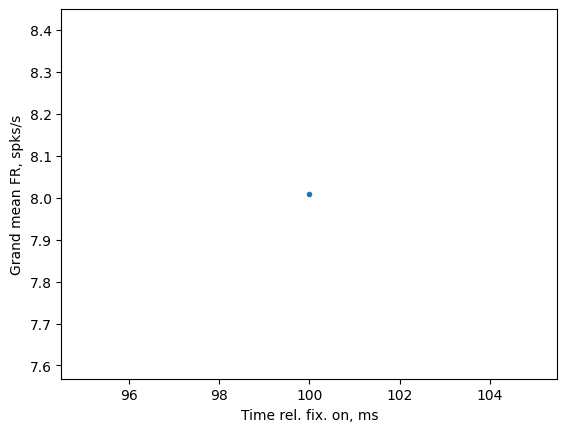

In [28]:
plt.plot(ts, resps.mean((0,2)), '.-')
plt.xlabel(f'Time rel. fix. on, ms')
plt.ylabel('Grand mean FR, spks/s');

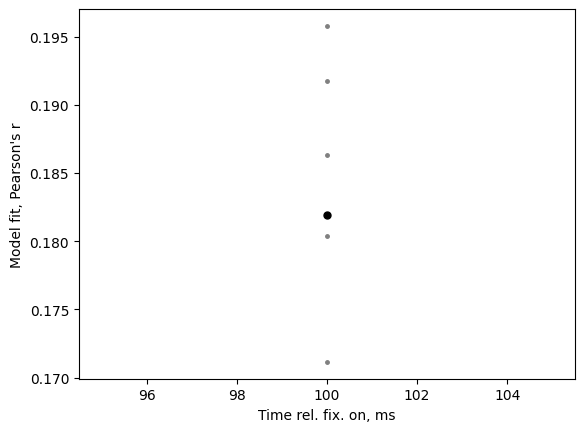

In [29]:
plt.plot(ts, np.nanmean(cv_corrs, axis=-1), '.-', c='k', lw=2, markersize=10)
plt.plot(ts, np.nanmean(cv_corrs_per_split, axis=-1), '.-', c='gray', lw=0.5, markersize=5)
plt.xlabel(f'Time rel. fix. on, ms')
plt.ylabel('Model fit, Pearson\'s r');